In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle

import awkward as ak
import mplhep as hep
import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
import re
import copy

import time
from timeout_decorator import timeout

from LoadBatch import *

verbose = False
debug = False

In [2]:
pd.set_option('display.max_columns', None)

!ls ../Data_TestBeam/2023_May/

'CERN Testbeam May 2023 - RunLog.csv'   configs   plots   S1   S2


In [3]:
# make list of files (merge.root)       v
# what are the variables that change for each file?

# (have a list of transimpedance values?)

# save the charge value from the fit

In [4]:
plt.style.use(hep.atlas.style.ATLAS)

In [5]:
# file = "../Data_TestBeam/2020_September/tree_September2020_106_000387.root"
# file = "../Data_TestBeam/2022_February/tree_February2022_502_000822.root"
# file = "../Data_TestBeam/2022_March/merge_March2022_201.root"
# file = "../Data_TestBeam/2022_October/batch302/merged_tracking_scope.root"

# other_df = root_to_df(file, branches)
# other_df

In [6]:
pixel_size = 0.0185 #mm

# choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins = (np.arange(450, 700, 1),
        np.arange(150, 500, 1))

small_bins = (np.arange(300, 800, 1),
              np.arange(0, 450, 1))

# Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")
dict_of_runs = read_pickle("dict_of_runs.pickle")
if verbose: 
    print(sensors_list)
    print(dict_of_runs)
    
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

Batch:  413
S1
DUT_0
DUT_1
DUT_2


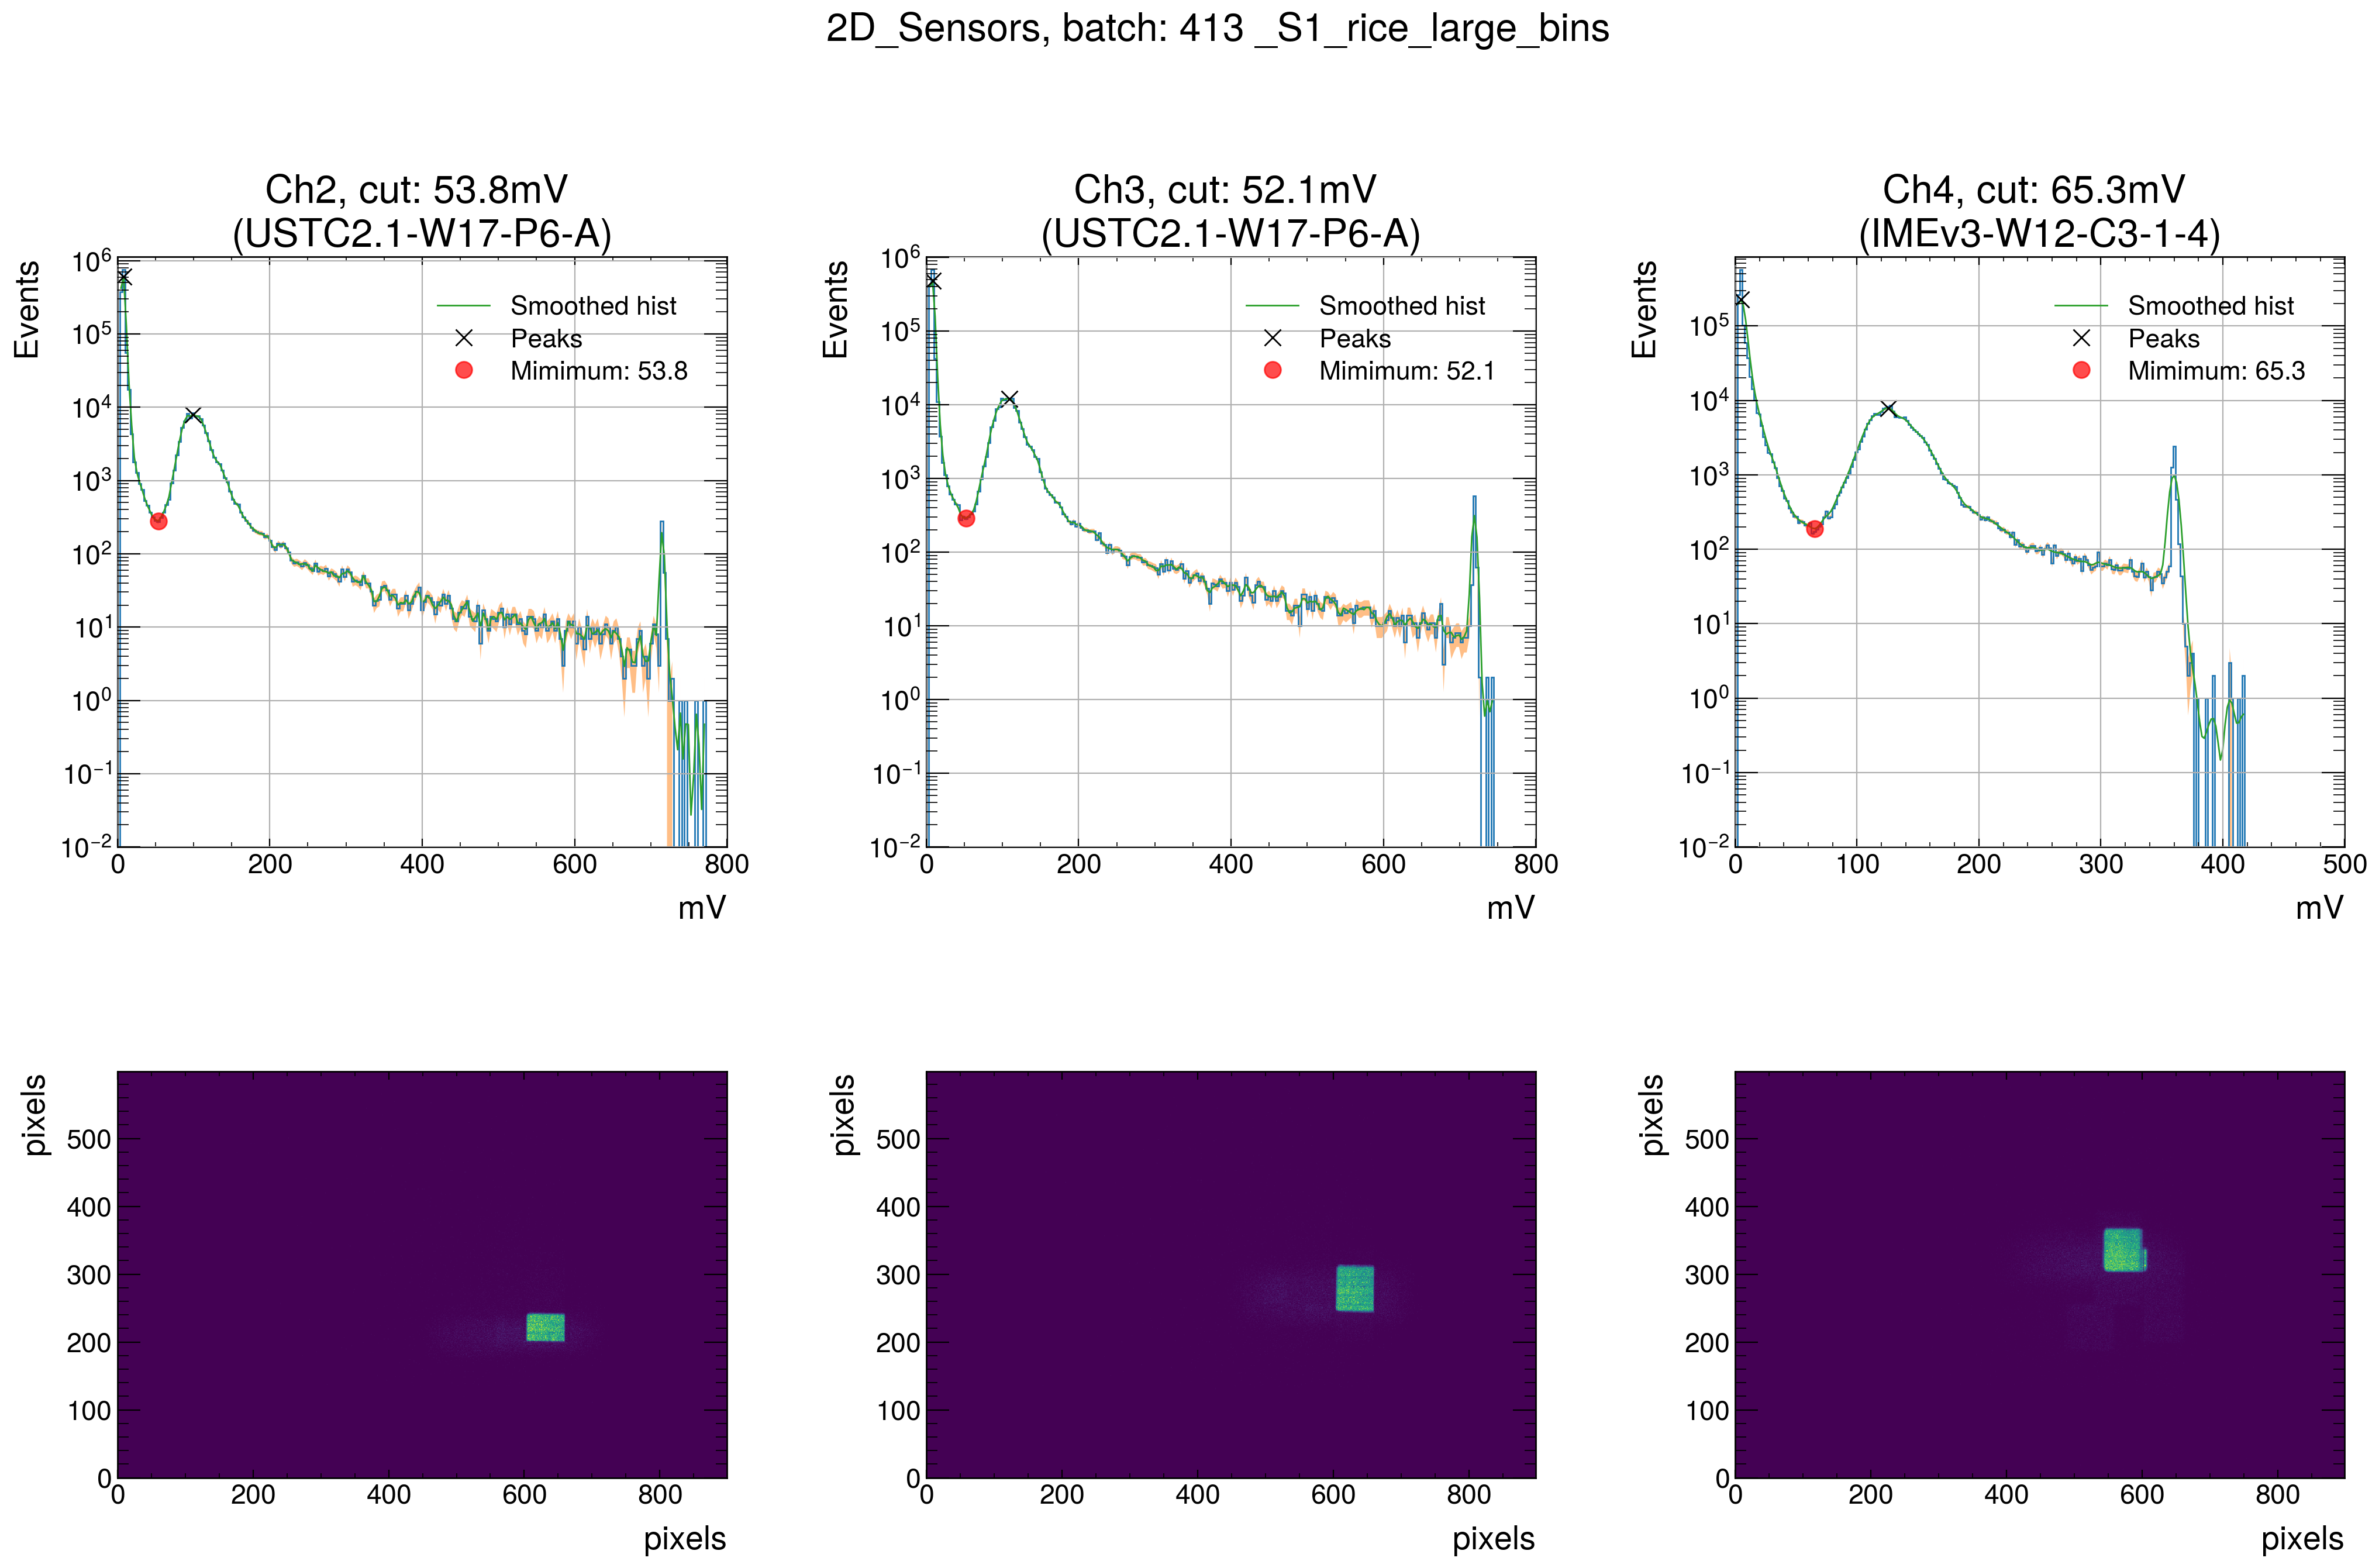

S2
DUT_0
DUT_1
DUT_2


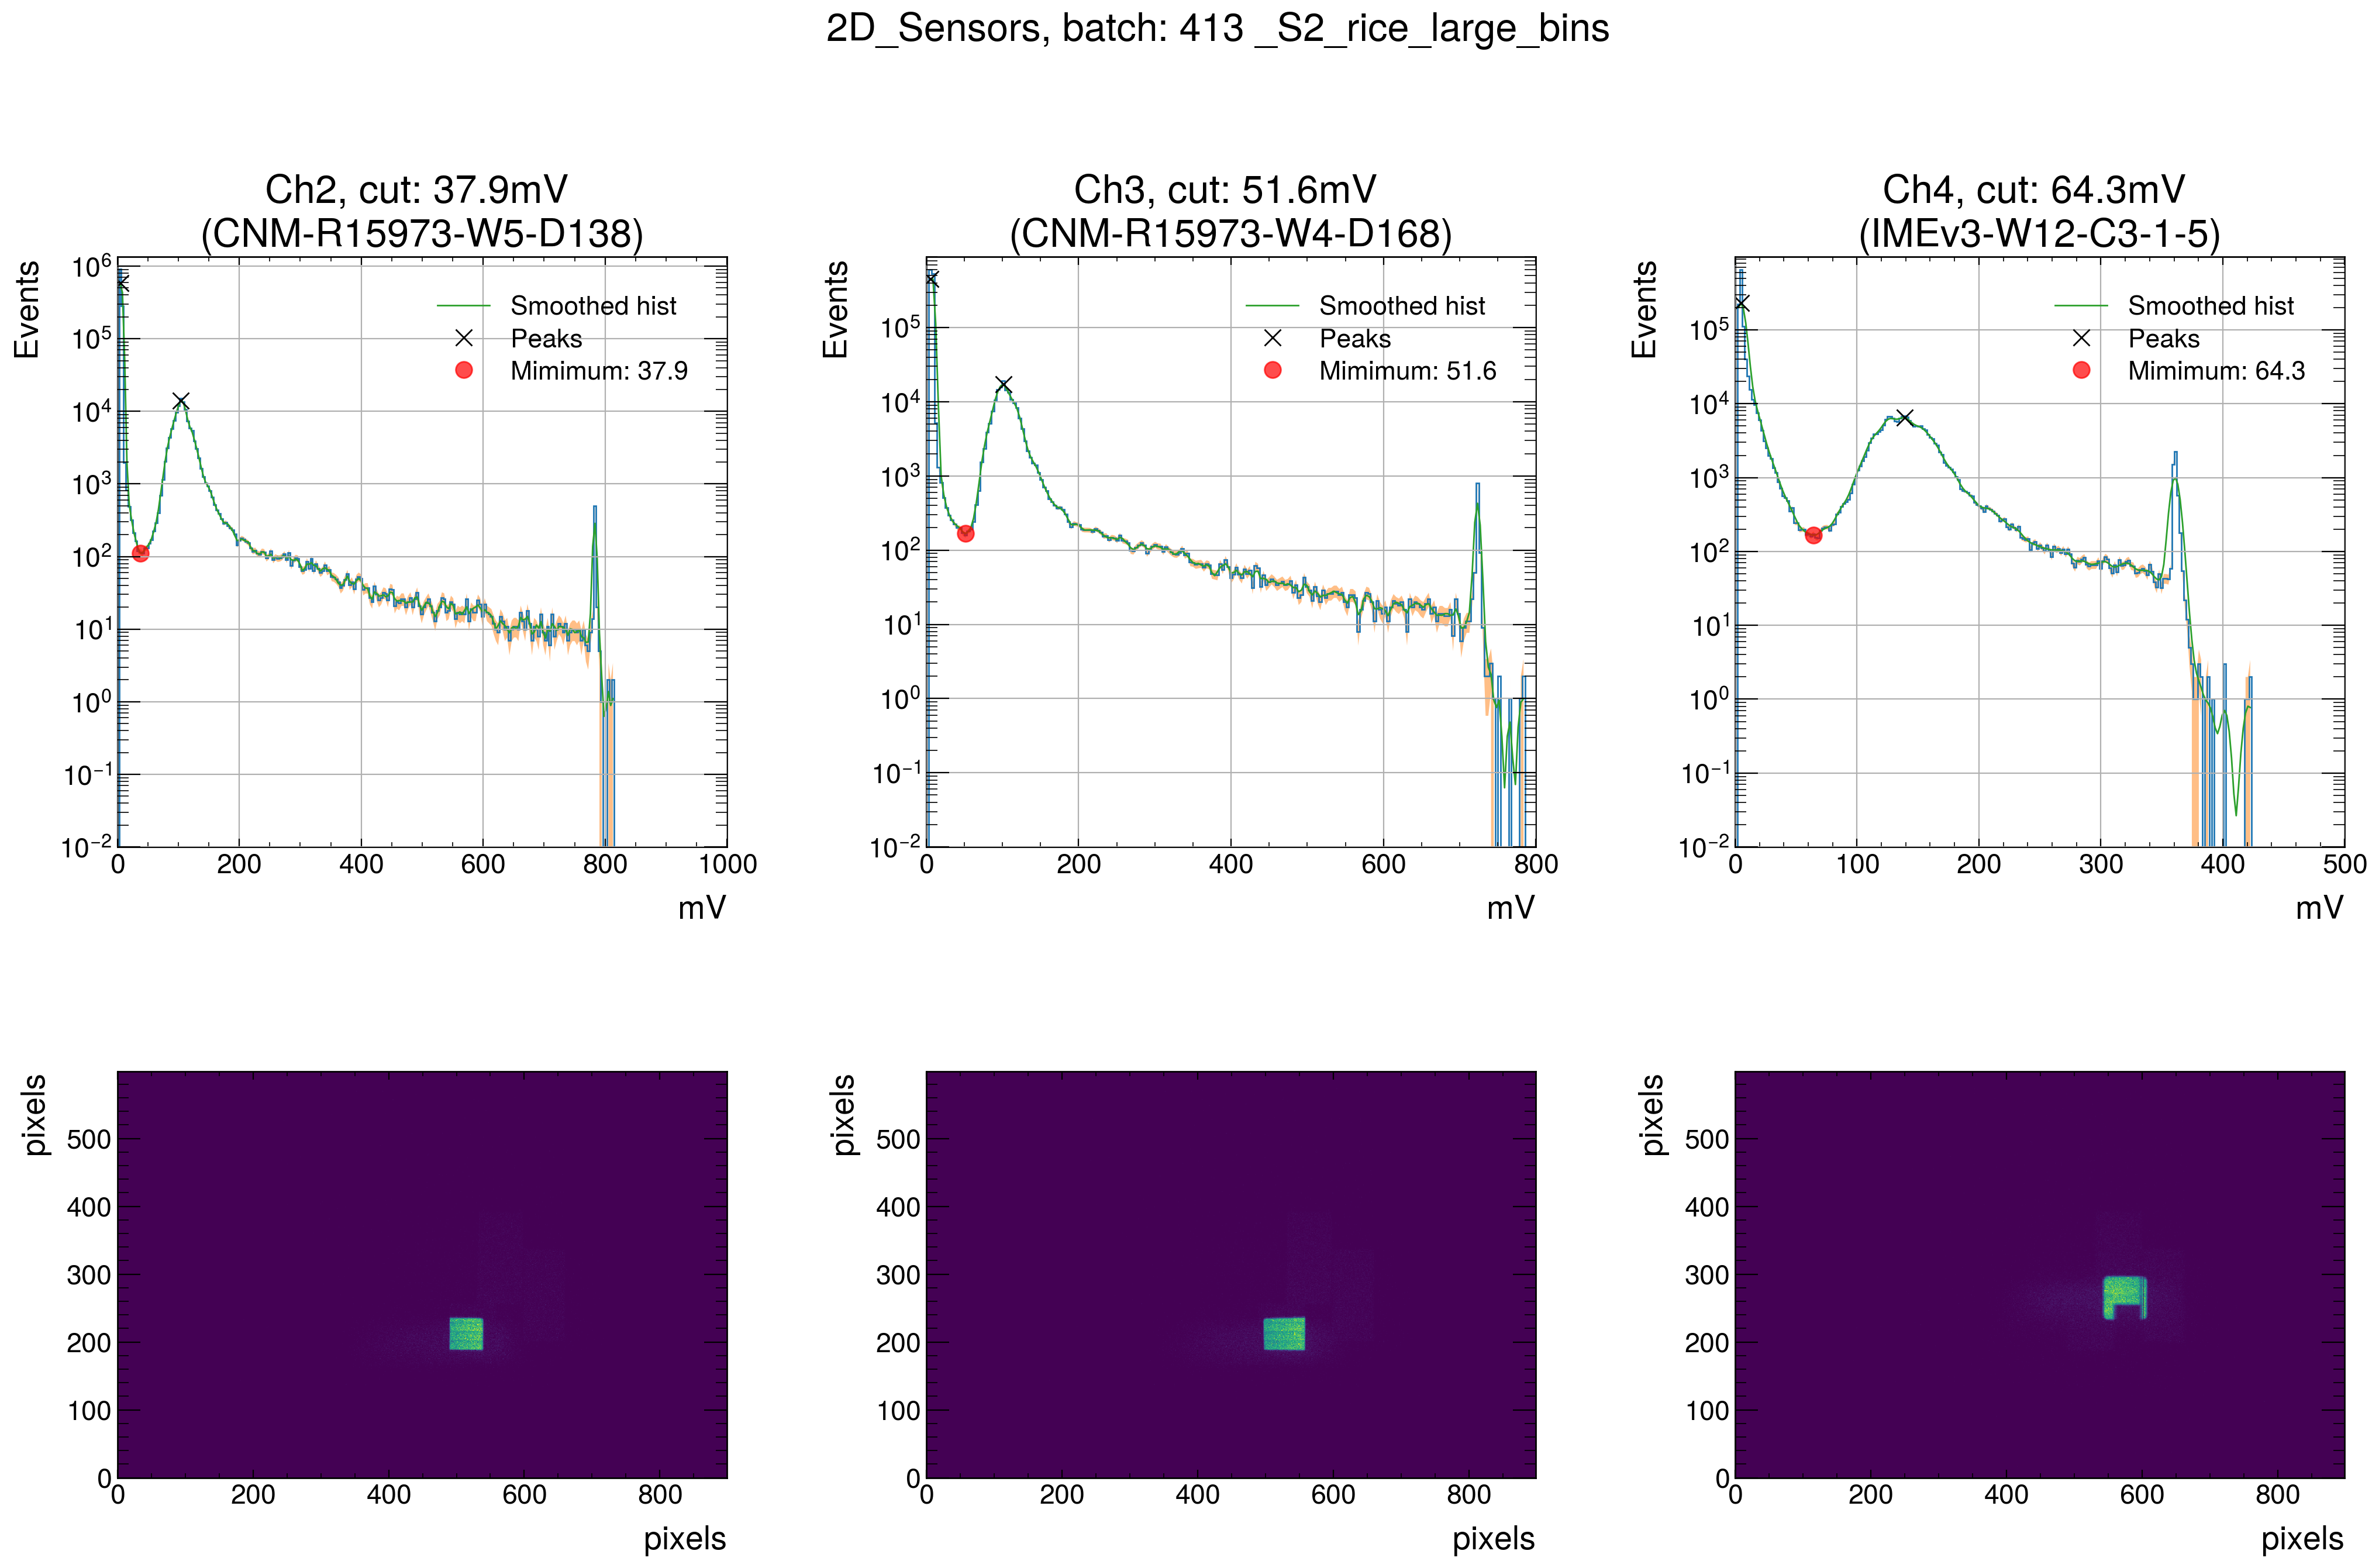

In [46]:
transimpedance = 4700 #ohm

this_batch = 413
print("Batch: ", this_batch)
dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes
method = 'rice'
for S in ["S1","S2"]: # the two scopes
    print(S)
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"    
    df[S] = root_to_df(os.path.join(dir_path[S], file_path), branches)
    df[S] = df[S].drop(columns=columns_to_remove)
#     plot(df[S], "1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=large_bins,
#      savefig=False, savefig_details=f'_{S}')
#     plot(df[S], "2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
    plot(df[S], "2D_Sensors", this_batch, sensors=sensors_list[this_batch][S], bins=large_bins, bins_find_min=method,
    savefig=False, savefig_details=f'_{S}_{method}_large_bins')
# plt.close('all')
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins,
# #     savefig=True, savefig_details='_S2')


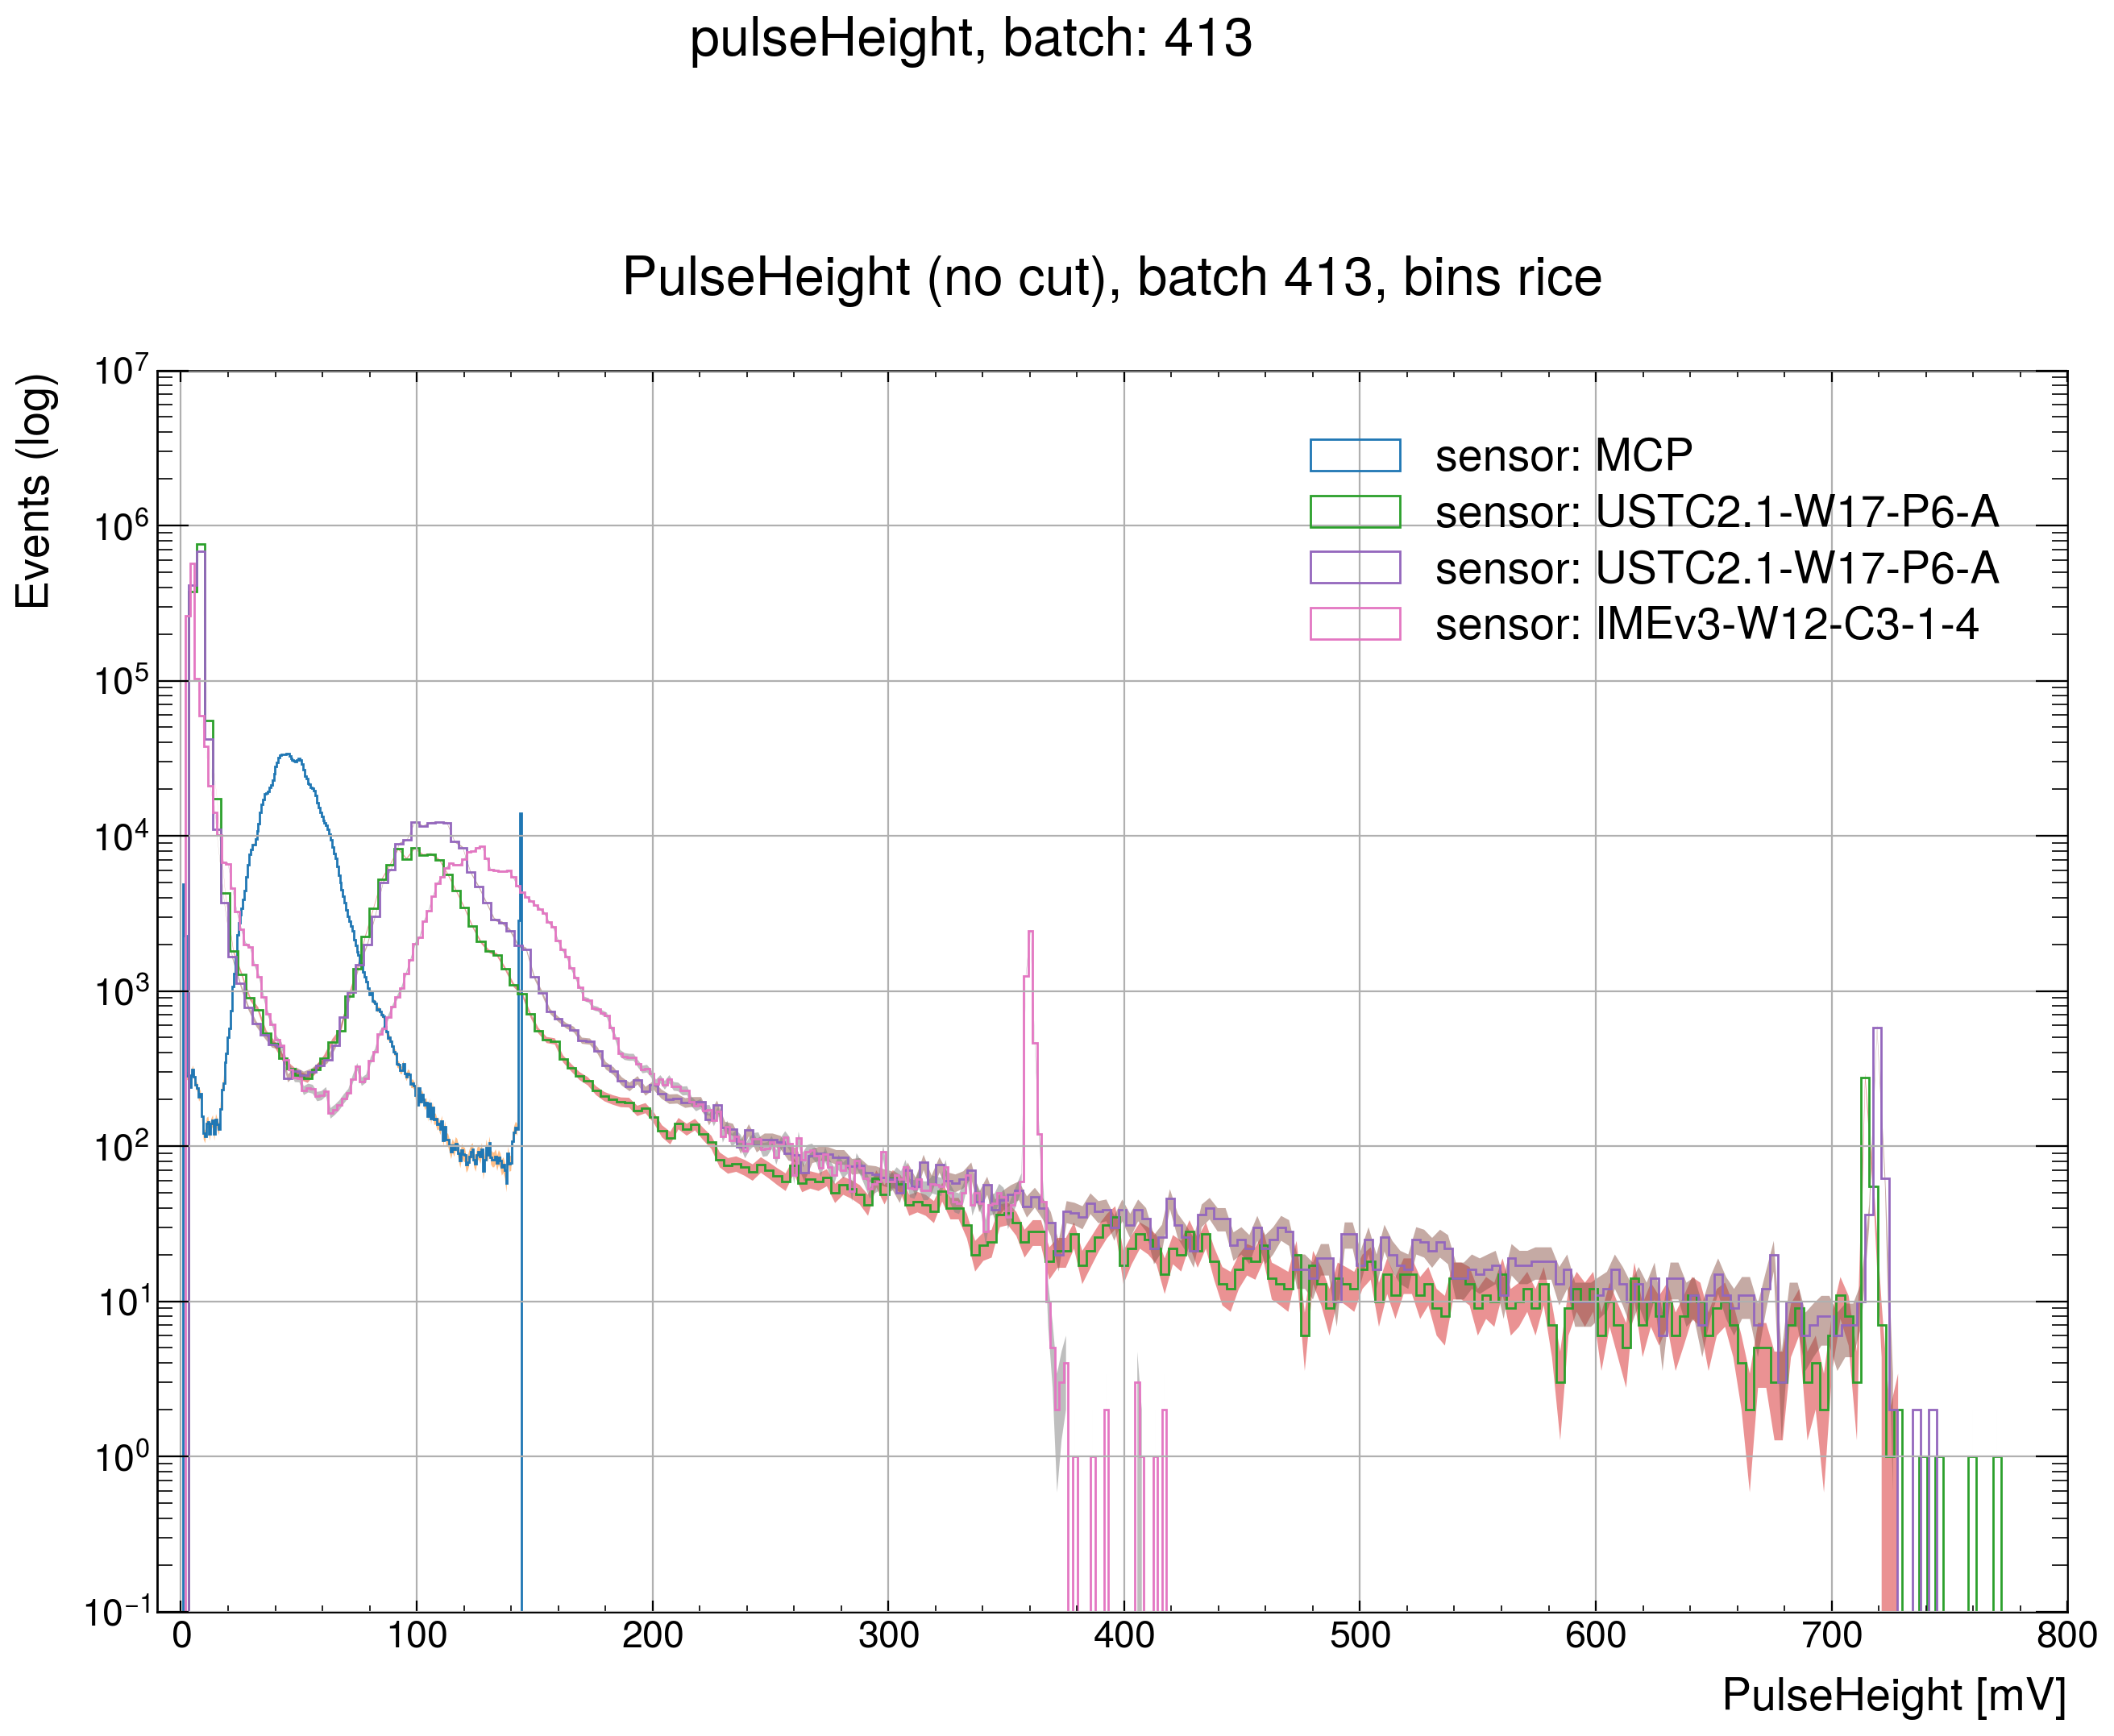

In [47]:
# find_min_btw_peaks(df["S1"]["pulseHeight_3"], bins='auto', plot=True)
data = df["S1"]
my_options = {'markersize':1, 'linewidth':0, 'alpha':0.5, 'elinewidth':0.5, 'capsize':1, 'errorevery':1}
plot(data, "pulseHeight", this_batch, bins='rice', sensors=sensors_list[this_batch]["S1"], **my_options);
### scott  or sqrt

In [48]:
np.sort(list(dict_of_runs["S1"].keys()))

array([ 100,  101,  199,  201,  202,  203,  204,  205,  206,  301,  401,
        402,  403,  406,  407,  408,  409,  410,  411,  413,  414,  501,
        502,  503,  504,  505,  601,  602,  603,  604,  605,  701,  702,
        801,  802,  901,  902, 1001, 1002, 1101, 1102, 1201, 1202])

In [10]:
### SAVE THE PLOTS FOR ALL BATCHES
binning_method = 'rice'
RUN_ALL_BATCHES = False
if RUN_ALL_BATCHES:
    for S in ["S1","S2"]: # the two scopes
        if S=="S1": continue
        for this_batch in np.sort(list(dict_of_runs[S].keys())):  ### I sort them so I can restart from the batch I want
            if this_batch>=407 and this_batch<=500:
                print("Batch: ", this_batch)
                dir_path = f"../Data_TestBeam/2023_May/{S}/"
                file_path = f"tree_May2023_{S}_{this_batch}.root"    
                try:
                    df = root_to_df(os.path.join(dir_path, file_path), branches)
                except:
                    print("something wrong reading the file")
                    continue
                df = df.drop(columns=columns_to_remove)
        #         plot(df,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
        #              savefig=True, savefig_details=f'_{S}')
    #             plot(df,"1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=large_bins,
    #                  savefig=True, savefig_details=f'_{S}')
        #         bins = 1000
        #         plot(df, "pulseHeight", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
        #             savefig=True, savefig_details=f"_{S}_bins_{bins}")
                    ### I think something is leaking memory!!!
                plot(df, '2D_Sensors', batch=this_batch, sensors=sensors_list[this_batch][S],
                     bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_large_bins')#_{binning_method}')
            plt.close('all') # I think this worked. maybe not actually

In [11]:
# I was trying to plot the FE-I4 mask but it does not quite work

# # Create a figure and axis
# fig, ax = plt.subplots()

# # Define the coordinates, width, and height of multiple rectangles
# rectangles = [(30,205,5,25), # x,y,width, height
# (35,205,5,25),
# (29,165,5,25),
# (29,160,5,25),
# (34,180,5,24),
# (39,180,15,24)]

# # Loop through the list of rectangles and draw them
# for rect in rectangles:
#     x, y, width, height = rect
#     ax.add_patch(mpatches.Rectangle((x, y), width, height, fill=True))

# # Set axis limits if needed
# ax.set_xlim(25, 60)
# ax.set_ylim(150, 240)

# # Display the plot
# plt.gca().set_aspect('equal', adjustable='box')  # Make sure aspect ratio is equal
# plt.show()

(<Figure size 3000x1200 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch4\n(IMEv3-W12-C3-1-4)'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

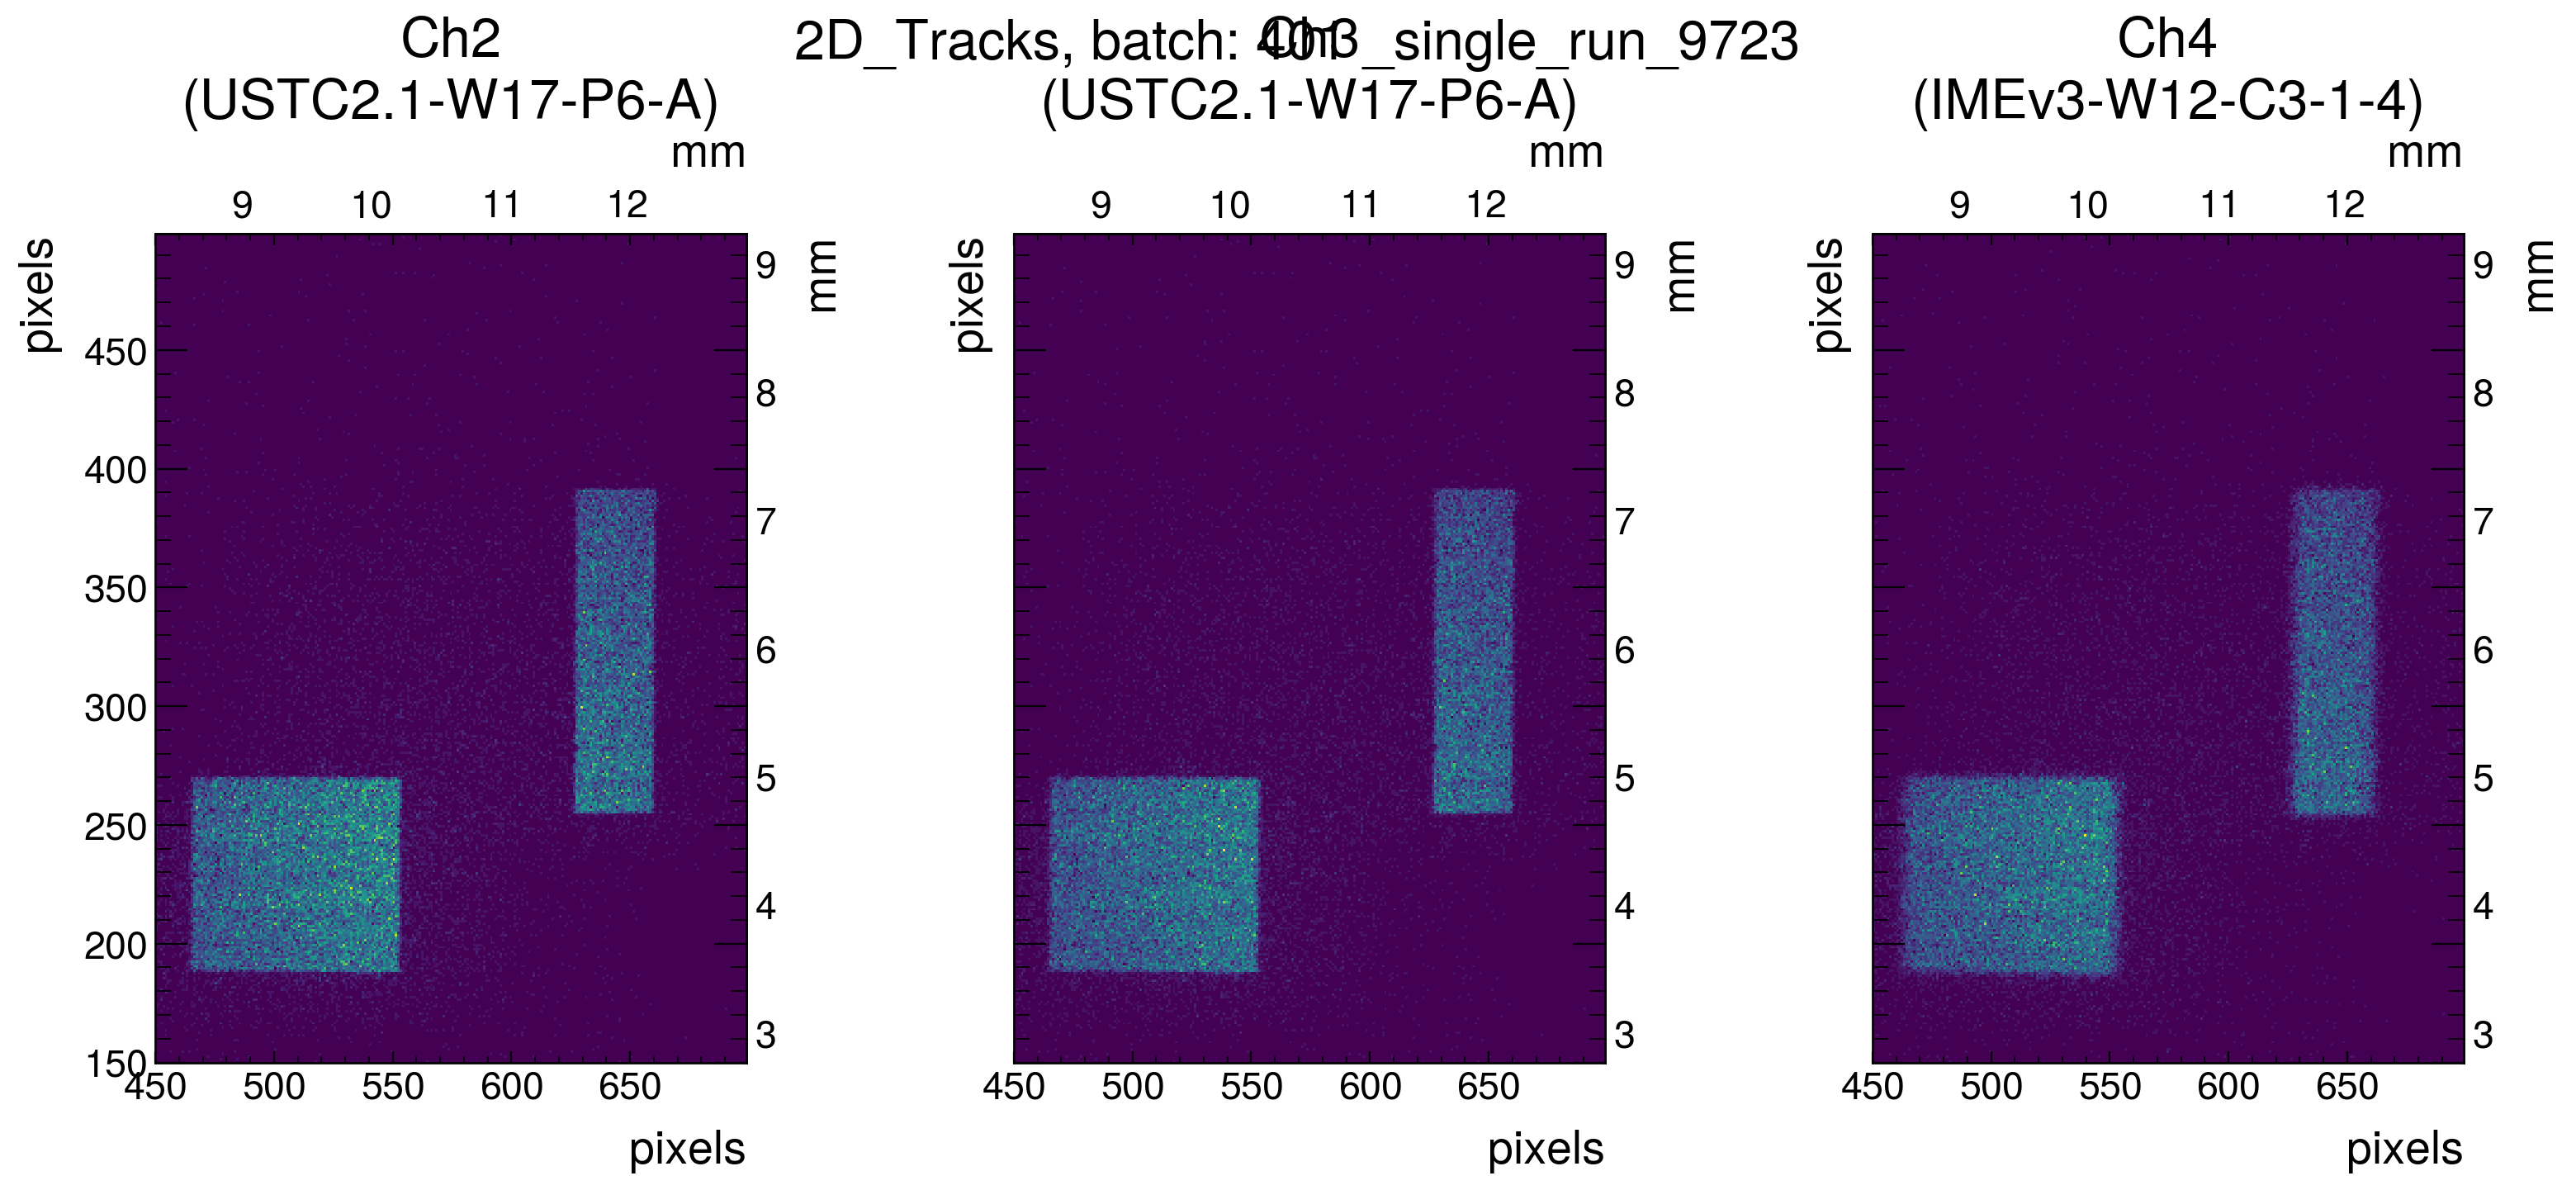

In [12]:
### looking at single runs 
dir_path = f"../Data_TestBeam/2023_May/S1/"
run = 9723
file_path = f"tree00{run}.root"    
df_run = root_to_df(os.path.join(dir_path, file_path), branches)
df_run = df_run.drop(columns=columns_to_remove)
    
plot(df_run,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=bins,
    savefig=True, savefig_details=f"_single_run_{run}")
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

In [13]:
# plot(df["S1"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=large_bins)
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=large_bins)

In [39]:
# plot(df["S2"], "1D_Tracks", this_batch, bins=large_bins, sensors=sensors_list[this_batch]["S2"])

In [40]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6), sharex=False, sharey=False, dpi=200)
# plot_histogram(df["S1"]["charge_1"], fig_ax=(fig,axes[0]))
# axes[1].hist2d(df["S1"]["Xtr_1"],df["S1"]["Ytr_1"]);
# axes[1].set_xlim()
# help(axes[1].step)

In [49]:
def plot(df, plot_type, batch, *, sensors=None, bins=None, bins_find_min='rice', n_DUT=3,
         savefig=False, savefig_path='../various plots', savefig_details='', fig_ax=None,
         **kwrd_arg):
    """
    Function to produce the plots \n
    Parameters
    ----------
    df:             FULL dataframe of the data to plot (each plot_type select the data it needs)
    plot_type:      type of plot, options are:
                        '2D_Tracks':    2D plot of the reconstructed tracks
                        '1D_Tracks':    histogram of reconstructed tracks distribution (Xtr and Ytr)
                        'pulseHeight':  histogram of the pulseHeight of all channels (log scale)
                        '2D_Sensors':   pulseHeight cut plot + 2D plot of tracks with cut (highlighting the sensors)
    batch:          batch number
    sensors:        dictionary of the sensors in this batch
    bins:           binning options, (int,int) or (bin_edges_list, bin_edges_list), different default for each plot_type
    bins_find_min:  binning options for the find_min_btw_peaks function (in '2D_Sensors')  
    n_DUT:          number of devices under test (3 for each Scope for May 2023)
    savefig:        boolean option to save the plot
    savefig_path:   folder where to save the plot
    savefig_details: optional details for the file name (e.g. distinguish cuts)

    Returns
    -------
    fig, axes:        figure and axis objects so that more manipulation can be done
    """
    match plot_type:
        case "2D_Tracks":        ### 2D tracks plots
            if fig_ax:  fig, axes = fig_ax
            else:       fig, axes = plt.subplots(nrows=1, ncols=n_DUT, figsize=(15,6), sharex='all', sharey='all', dpi=200)
            fig.tight_layout(w_pad=6, h_pad=4)
            if not bins: bins = (200,200)   ### default binning
            for i in range(n_DUT):
                hist, _, _, _, = axes[i].hist2d(df[f"Xtr_{i}"], df[f"Ytr_{i}"], bins=bins, **kwrd_arg)
                if sensors: axes[i].set_title(f"Ch{i+2}\n({sensors[f'Ch{i+2}']})")
                else: axes[i].set_title(f"Ch{i+2}")
                axes[i].set_aspect('equal')
                axes[i].set_xlabel('pixels', fontsize=20)
                axes[i].set_ylabel('pixels', fontsize=20)
                secx = axes[i].secondary_xaxis('top', functions=(lambda x: x*PIXEL_SIZE, lambda x: x*PIXEL_SIZE))
                secy = axes[i].secondary_yaxis('right', functions=(lambda x: x*PIXEL_SIZE, lambda x: x*PIXEL_SIZE))
                secx.set_xlabel('mm', fontsize=20)
                secy.set_ylabel('mm', fontsize=20)

        case "1D_Tracks":        ### 1D tracks plots
            if fig_ax:  fig, axes = fig_ax
            else:       fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), dpi=200, sharey='all')
            if not bins: bins = (200,200)   ### default binning
            for i in range(n_DUT):
                plot_histogram(df[f"Xtr_{i}"], label=f"Xtr_{i}", bins=bins[0], fig_ax=(fig,axes[0]), **kwrd_arg)
                plot_histogram(df[f"Ytr_{i}"], label=f"Ytr_{i}", bins=bins[1], fig_ax=(fig,axes[1]), **kwrd_arg)
            for ax in axes:     ### modify both axes
                ax.legend(fontsize=16)
                ax.semilogy()
                ax.set_xlabel('pixels', fontsize=20)
                ax.set_ylabel('Events (log)', fontsize=20)

        case "pulseHeight":       ### PulseHeight plot
            if fig_ax:  fig, axes = fig_ax
            else:       fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10), dpi=200)
            if not bins: bins = 'rice'
            for i in range(n_DUT+1):
                if sensors: sensor_label=f"sensor: {sensors[f'Ch{i+1}']}"
                else: sensor_label=f'Ch{i+1}'
                plot_histogram(df[f"pulseHeight_{i}"], poisson_err=True, error_band=True, bins=bins, fig_ax=(fig,axes), label=sensor_label, **kwrd_arg)
            axes.semilogy()
            axes.set_xlabel("PulseHeight [mV]", fontsize=20)
            axes.set_ylabel("Events (log)", fontsize=20)
            axes.set_title(f"PulseHeight (no cut), batch {batch}, bins {bins}", fontsize=24, y=1.05)
            axes.set_xlim(left=-10)
            axes.legend(fontsize=20)
            
        case "2D_Sensors":        ### 2D tracks plots filtering some noise out (pulseHeight cut)
            if fig_ax:  fig, axes = fig_ax
            else:       fig, axes = plt.subplots(nrows=2, ncols=n_DUT, figsize=(20,12), sharex=False, sharey=False, dpi=200)
            if not bins: bins = (200,200)   ### default binning
            fig.tight_layout(w_pad=6, h_pad=4)
            for i in range(n_DUT):
                print(f"DUT_{i}")                   ### BINS: scott, rice or sqrt; stone seems slow, rice seems the fastest
                minimum = find_min_btw_peaks(df[f"pulseHeight_{i+1}"], bins=bins_find_min, plot=True, fig_ax=(fig,axes[0,i]),
                                             savefig=False, savefig_details=f"_{batch}_DUT{i}"+savefig_details)
                axes[0,i].set_xlabel('mV')
                axes[0,i].set_ylabel('Events')
                if not minimum:
                    print("No minimum found, no 2D plot")
                    axes[0,i].set_title(f"Ch{i+2} \n({sensors[f'Ch{i+2}']})")
                    continue
                if sensors: axes[0,i].set_title(f"Ch{i+2}, "+"cut: %.1f"%minimum+f"mV \n({sensors[f'Ch{i+2}']})")
                else: axes[0,i].set_title(f"Ch{i+2}")
                pulseHeight_filter = np.where(df[f"pulseHeight_{i+1}"]>minimum)
                axes[1,i].hist2d(df[f"Xtr_{i}"].iloc[pulseHeight_filter], df[f"Ytr_{i}"].iloc[pulseHeight_filter],
                                                bins=bins, **kwrd_arg)
                axes[1,i].set_aspect('equal')
                axes[1,i].set_xlabel('pixels', fontsize=20)
                axes[1,i].set_ylabel('pixels', fontsize=20)

        case "1D_Efficiency":
            for key, value in kwrd_arg.items():
                match key:
                    case 'threshold_charge': threshold_charge=value
                    case 'transimpedance':   transimpedance=value
                    case other: print(f"invalid argument: {other}")
            coord = ['X','Y']
            if fig_ax:  fig, axes = fig_ax
            else:       fig, axes = plt.subplots(nrows=2, ncols=n_DUT, figsize=(20,12), sharex=False, sharey=False, dpi=200)
            fig.tight_layout(w_pad=6, h_pad=4)

            for i in range(n_DUT):
### I can probably make this part into a function: 'geometry_mask(df, bins, bins_find_min)'
                min_value = find_min_btw_peaks(df[f"pulseHeight_{i+1}"], bins=bins_find_min, plot=False)
                pulseHeight_filter = np.where(df[f"pulseHeight_{i+1}"]>min_value)
                Xtr_cut = df[f"Xtr_{i}"].iloc[pulseHeight_filter]       ### X tracks with applied pulseHeight
                Ytr_cut = df[f"Ytr_{i}"].iloc[pulseHeight_filter]
                left_edge, right_edge = find_edges(Xtr_cut, bins=bins[0], use_kde=True, plot=False)
                bottom_edge, top_edge = find_edges(Ytr_cut, bins=bins[1], use_kde=True, plot=False)
                xgeometry = np.logical_and(df[f"Xtr_{i}"]>left_edge, df[f"Xtr_{i}"]<right_edge)
                ygeometry = np.logical_and(df[f"Ytr_{i}"]>bottom_edge, df[f"Ytr_{i}"]<top_edge)
### that returns bool_geometry
                bool_geometry = np.logical_and(xgeometry, ygeometry)    ### this is a boolean mask of the selected positions
                geometry = np.where(bool_geometry)   ### this is the array of indices of the selected values
            ### Create a boolean mask for events above the threshold
                events_above_threshold = df[f"charge_{i+1}"].iloc[geometry]/transimpedance > threshold_charge
            ### Calculate the number of events above threshold in each bin
                for coord_idx, XY in enumerate(coord):
                    above_threshold = np.where(np.logical_and(bool_geometry, events_above_threshold))
                    total_events_in_bin, bins_edges, _, _, _ = plot_histogram(df[f"{XY}tr_{i}"].iloc[geometry], bins=bins[coord_idx], fig_ax=(fig, axes[coord_idx,i]))
                    events_above_threshold_in_bin, _, _, _, _ = plot_histogram(df[f"{XY}tr_{i}"].iloc[above_threshold], bins=bins[coord_idx], fig_ax=(fig, axes[coord_idx,i]))
                    axes[coord_idx, i].clear()
                    bins_centers = (bins_edges[:-1]+bins_edges[1:])/2
                    eff, err = efficiency_k_n(events_above_threshold_in_bin, total_events_in_bin)
                    axes[coord_idx,i].step(bins_centers, eff*100, where='mid', label=f"Ch{i+1}")
                    sigma_coeff = 1
                    axes[coord_idx,i].errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
                                label=f"error: {sigma_coeff}$\sigma$")
                    axes[coord_idx,i].set_title(f"{XY} axis projection of efficiency", fontsize=24, y=1.05)
                    axes[coord_idx,i].set_xlabel(f"{XY} position (pixels)", fontsize=20)
                    axes[coord_idx,i].set_ylabel("Efficiency", fontsize=20)
                    # axes[coord_idx,i].legend()
                    if XY=='X': axes[coord_idx,i].set_xlim(left_edge,right_edge)
                    if XY=='Y': axes[coord_idx,i].set_xlim(bottom_edge,top_edge)
                    # axes[coord_idx,i].set_ylim(bottom_edge,top_edge)

        case "2D_Efficiency":
            if fig_ax:  fig, axes = fig_ax
            else:       fig, axes = plt.subplots(nrows=1, ncols=n_DUT, figsize=(15,6), sharex=False, sharey=False, dpi=200)
            fig.tight_layout(w_pad=8, h_pad=6)
            for key, value in kwrd_arg.items():
                match key:
                    case 'threshold_charge': threshold_charge=value
                    case 'transimpedance':   transimpedance=value
                    case other: print(f"invalid argument: {other}")
            for i in range(n_DUT):
                min_value = find_min_btw_peaks(df[f"pulseHeight_{i+1}"], bins=bins_find_min, plot=False)
                pulseHeight_filter = np.where(df[f"pulseHeight_{i+1}"]>min_value)
                Xtr_cut = df[f"Xtr_{i}"].iloc[pulseHeight_filter]       ### X tracks with applied pulseHeight
                Ytr_cut = df[f"Ytr_{i}"].iloc[pulseHeight_filter]
                left_edge, right_edge = find_edges(Xtr_cut, bins=bins[0], use_kde=True, plot=False)
                bottom_edge, top_edge = find_edges(Ytr_cut, bins=bins[1], use_kde=True, plot=False)
                xgeometry = np.logical_and(df[f"Xtr_{i}"]>left_edge, df[f"Xtr_{i}"]<right_edge)
                ygeometry = np.logical_and(df[f"Ytr_{i}"]>bottom_edge, df[f"Ytr_{i}"]<top_edge)
                bool_geometry = np.logical_and(xgeometry, ygeometry)    ### this is a boolean mask of the selected positions
                geometry = np.where(bool_geometry)   ### this is the array of indices of the selected values
                total_events_in_bin, x_edges, y_edges, _ = axes[i].hist2d(df[f"Xtr_{i}"].iloc[geometry], df[f"Ytr_{i}"].iloc[geometry], bins=bins)
        ### Create a boolean mask for events above the threshold
                events_above_threshold = df[f"charge_{i+1}"].iloc[geometry]/transimpedance > threshold_charge
        ### Calculate the number of events above threshold in each bin
                above_threshold = np.where(np.logical_and(bool_geometry, events_above_threshold))
                events_above_threshold_in_bin, _, _, _ = axes[i].hist2d(df[f"Xtr_{i}"].iloc[above_threshold], df[f"Ytr_{i}"].iloc[above_threshold], bins=bins)
                efficiency_map = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                                        where=total_events_in_bin!=0,
                                        out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage
                axes[i].clear()
                # fig = plt.figure(figsize=(7.28, 6), dpi=200)    ### I need to be able to plot 3 in the same
                axes[i].imshow(efficiency_map.T, origin='lower',# extent=[left_edge, right_edge, bottom_edge, top_edge],
                        aspect='equal', vmin=0, vmax=100)
                # axes[i].colorbar(label='Efficiency')
                axes[i].set_xlabel('X Position', fontsize=20)
                axes[i].set_ylabel('Y Position', fontsize=20)
                # axes = None


        case other:
            print("""No plot_type found, options are:
            '2D_Tracks', '1D_Tracks', 'pulseHeight', '2D_Sensors' """)
            return
    
    fig.suptitle(f"{plot_type}, batch: {batch} {savefig_details}", fontsize=24, y=1.15)
    plt.show()
    if savefig: fig.savefig(f"{savefig_path}/{plot_type}_{batch}{savefig_details}.jpg", bbox_inches="tight")
    return fig, axes

    # Efficiency Xtr Ytr


    # Efficiency 2D plot


# if __name__ == '__main__':
#     main()

## Improved efficiency study

In [52]:
plot(df["S1"], "1D_Efficiency", this_batch, bins=bins, threshold_charge=2, transimpedance=4700, savefig=True, savefig_details='charge: 2fC')

in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist


(<Figure size 4000x2400 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'X axis projection of efficiency'}, xlabel='X position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'X axis projection of efficiency'}, xlabel='X position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'X axis projection of efficiency'}, xlabel='X position (pixels)', ylabel='Efficiency'>],
        [<AxesSubplot:title={'center':'Y axis projection of efficiency'}, xlabel='Y position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'Y axis projection of efficiency'}, xlabel='Y position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'Y axis projection of efficiency'}, xlabel='Y position (pixels)', ylabel='Efficiency'>]],
       dtype=object))

In [51]:
plot(df["S1"], "2D_Efficiency", this_batch, bins=bins, threshold_charge=2, transimpedance=10700, savefig=True)

in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist


(<Figure size 3000x1200 with 3 Axes>,
 array([<AxesSubplot:xlabel='X Position', ylabel='Y Position'>,
        <AxesSubplot:xlabel='X Position', ylabel='Y Position'>,
        <AxesSubplot:xlabel='X Position', ylabel='Y Position'>],
       dtype=object))

In [ ]:
# data = df["S1"]
# idx_of_DUT = 0  ### 0,1,2
# my_bins = large_bins

# ### Find minimum
# min_value = find_min_btw_peaks(data[f"pulseHeight_{idx_of_DUT+1}"], bins='rice', plot=False)

# ### Apply pulseHeight cut
# pulseHeight_filter = np.where(data[f"pulseHeight_{idx_of_DUT+1}"]>min_value)
# Xtr_cut = data[f"Xtr_{idx_of_DUT}"].iloc[pulseHeight_filter]
# Ytr_cut = data[f"Ytr_{idx_of_DUT}"].iloc[pulseHeight_filter]
# # x_kde = gaussian_kde(Xtr_cut)
# # x_bins_centers = (my_bins[0][:-1]+my_bins[0][1:])/2
# # x_kde_evaluated = x_kde.evaluate(x_bins_centers)
# # plt.plot(x_bins_centers, x_kde_evaluated)  ### this is normalized, and find_edges is not
# # plt.plot(bins[0],kde.evaluate(bins[0]))
# # hist, x_bins, y_bins, _ = plt.hist2d(Xtr_cut, Ytr_cut, bins=large_bins);

# ### Find edges
# left_edge, right_edge = find_edges(Xtr_cut, bins=my_bins[0], plot=False)
# bottom_edge, top_edge = find_edges(Ytr_cut, bins=my_bins[1], plot=False)
# print(left_edge, right_edge)
# print(bottom_edge, top_edge)
# # print(bins_centers[np.argmax(np.gradient(kde_evaluated))], bins_centers[np.argmin(np.gradient(kde_evaluated))])
# # print(find_edges(Ytr_cut, bins=bins[1], plot=True))

# ### Define geometry filter
# xgeometry = np.logical_and(data[f"Xtr_{idx_of_DUT}"]>left_edge, data[f"Xtr_{idx_of_DUT}"]<right_edge)
# ygeometry = np.logical_and(data[f"Ytr_{idx_of_DUT}"]>bottom_edge, data[f"Ytr_{idx_of_DUT}"]<top_edge)
# bool_geometry = np.logical_and(xgeometry, ygeometry)    ### this is a boolean mask of the selected positions
# geometry = np.where(bool_geometry)   ### this is the array of indices of the selected values

# ### Calculate efficiency per bin
#     ### I need the charge for this
#         ### I need transimpedance for this

# charge_threshold = 2 #fC
# transimpedance = 4700 
# # bins = (x_bins_pixels, y_bins_pixels)

# total_events_in_bin, x_edges, y_edges, _ = plt.hist2d(data[f"Xtr_{idx_of_DUT}"].iloc[geometry],
#                                                     data[f"Ytr_{idx_of_DUT}"].iloc[geometry], bins=my_bins)
# # Create a boolean mask for events above the threshold
# events_above_threshold = data[f"charge_{idx_of_DUT+1}"].iloc[geometry]/transimpedance > charge_threshold

#  # Calculate the number of events above threshold in each bin
# above_threshold = np.where(np.logical_and(bool_geometry, events_above_threshold))
# events_above_threshold_in_bin, _, _, _ = plt.hist2d(data[f"Xtr_{idx_of_DUT}"].iloc[above_threshold],
#                                                     data[f"Ytr_{idx_of_DUT}"].iloc[above_threshold],
#                                                     bins=my_bins)
# # plt.axis('equal')

# # Calculate the efficiency for each bin
# efficiency_map = np.divide(events_above_threshold_in_bin, total_events_in_bin,
#                            where=total_events_in_bin!=0,
#                            out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage
# plt.close()

# ### 2D plot of efficiency



In [ ]:
fig = plt.figure(figsize=(7.28, 6), dpi=200)
plt.imshow(efficiency_map.T, origin='lower',# extent=[left_edge, right_edge, bottom_edge, top_edge],
           aspect='equal', vmin=0, vmax=100)
# fig.tight_layout(pad=7)
plt.colorbar(label='Efficiency')
plt.xlabel('X Position', fontsize=20)
plt.ylabel('Y Position', fontsize=20)
plt.title(f'2D Efficiency restricted to ~1.3x1.3mm² \n (Charge > {charge_threshold} fC)',
         fontsize=24, y=1.05)
# plt.axis('equal')
plt.xlim(round(left_edge), round(right_edge))
plt.ylim(round(bottom_edge), round(top_edge))
plt.show()

In [ ]:
# # figure out the geometry cut and put it into a dict
# edges = {}
# edges["Ch2"] = {}

# edges["Ch2"]["left"], edges["Ch2"]["right"] = find_edges(Xtr_1cut) # previous Xtr cut
# edges["Ch2"]["bottom"], edges["Ch2"]["top"] = find_edges(Ytr_1cut)
# xgeometry_1 = (df[this_scope]["Xtr_1"]>edges["Ch2"]["left"]).combine((
#                 df[this_scope]["Xtr_1"]<edges["Ch2"]["right"]), my_and)
# ygeometry_1 = (df[this_scope]["Ytr_1"]>edges["Ch2"]["bottom"]).combine((
#                 df[this_scope]["Ytr_1"]<edges["Ch2"]["top"]), my_and) 
# geometry_1 = xgeometry_1.combine(ygeometry_1, my_and)

# edges["Ch3"] = {}
# edges["Ch3"]["left"], edges["Ch3"]["right"] = find_edges(Xtr_2cut) 
# edges["Ch3"]["bottom"], edges["Ch3"]["top"] = find_edges(Ytr_2cut)
# xgeometry_2 = (df[this_scope]["Xtr_2"]>edges["Ch3"]["left"]).combine((
#                 df[this_scope]["Xtr_2"]<edges["Ch3"]["right"]), my_and)
# ygeometry_2 = (df[this_scope]["Ytr_2"]>edges["Ch3"]["bottom"]).combine((
#                 df[this_scope]["Ytr_2"]<edges["Ch3"]["top"]), my_and) 
# geometry_2 = xgeometry_2.combine(ygeometry_2, my_and)

In [ ]:
# left_edge, right_edge = find_edges(Xtr_1cut)

# fig, ax = plt.subplots(figsize=(15,8))
# hist, bins, _ = plt.hist(Xtr_1cut, bins=bins[0], histtype='step')#, label=f'Xtr sensor: {these_sensors[1]}')
# ax.plot((bins[:-1]+bins[1:])/2, np.gradient(hist), label='gradient of Xtr')
# ax.axvline(left_edge, color='g', linestyle='--', label='left edge')
# ax.axvline(right_edge, color='r', linestyle='--', label='right edge')
# # ax.set_title(f"Xtr_1 distribution of {these_sensors[1]} (with pulseheight cut)", fontsize=24, y=1.05)
# ax.set_xlim(400,900)
# ax.set_xlabel("Position (pixels)", fontsize=20)
# ax.set_ylabel("Events", fontsize=20)
# ax.grid('--')
# ax.legend(fontsize=20, loc='upper left')

# # fig.savefig(f"various plots/locating_edges_Xtr_of_{these_sensors[1]}.jpg")

In [ ]:
data_pulse_filter = df["S1"]["charge_2"].iloc[np.where(filter_2)]/transimpedance
data_pulse_geo_filter = df["S1"]["charge_2"].iloc[np.where(filter_2 & geometry_2)]/transimpedance
data_geo_filter = df["S1"]["charge_2"].iloc[np.where(geometry_2)]/transimpedance

# I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _ = ax.hist(df["S1"]["charge_2"]/transimpedance, bins='auto', label="no cut", histtype='step', alpha=.5, color='#0000ff')
add_histogram(ax, data_pulse_filter, bins=bins_for_all, label="pulseheight cut", alpha=.5, color='#00ff00')
add_histogram(ax, data_pulse_geo_filter, bins=bins_for_all, label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
add_histogram(ax, data_geo_filter, bins=bins_for_all, label="geometry cut", alpha=.5, color='#505050') # #ffff00
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot with various cuts", fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,50)
ax.semilogy()
ax.legend(fontsize=20)

fig.savefig(f"various plots/charge_plot_various_cuts_{this_batch}.jpg")

In [ ]:
print(find_edges(Xtr_1cut), find_edges(Ytr_1cut))
# (right_edge-left_edge)*pixel_size
# (top_edge-bottom_edge)*pixel_size

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=300, sharex='all', sharey='all')
fig.tight_layout(w_pad=4)

Xtr_0 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_0 = df[this_scope]["Ytr_1"]#*pixel_size
ax[0].hist2d(Xtr_0, Ytr_0, bins=(x_bins, y_bins))
ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch1']} (Ch1)")

Xtr_1geo = df[this_scope]["Xtr_1"].iloc[np.where(filter_1 & geometry_1)]#*pixel_size
Ytr_1geo = df[this_scope]["Ytr_1"].iloc[np.where(filter_1 & geometry_1)]#*pixel_size
ax[1].hist2d(Xtr_1geo, Ytr_1geo, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")

Xtr_2cut = df[this_scope]["Xtr_2"].iloc[np.where(filter_2 & geometry_2)]#*pixel_size
Ytr_2cut = df[this_scope]["Ytr_2"].iloc[np.where(filter_2 & geometry_2)]#*pixel_size
ax[2].hist2d(Xtr_2cut, Ytr_2cut, bins=(x_bins, y_bins))
ax[2].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")

# fig.suptitle(f'Hit positions on batch 301', size=16)

for ax_single in ax:
#     ax_single.axis('equal')
    ax_single.set_xlim(**x_lim)
    ax_single.set_ylim(**y_lim)
    ax_single.set_xlabel('pixels')
    ax_single.set_ylabel('pixels')
    secx = ax_single.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax_single.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm')
    secy.set_ylabel('mm')

fig.savefig(f"various plots/hits_on_USTC_{this_batch}_geometry_cut.jpg", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.tight_layout(w_pad=5)

Xtr_1cut = df[this_scope]["Xtr_1"].iloc[np.where(filter_1)]#*pixel_size
Ytr_1cut = df[this_scope]["Ytr_1"].iloc[np.where(filter_1)]#*pixel_size

ax[0].hist2d(Xtr_1cut, Ytr_1cut, bins=(x_bins,y_bins))
# ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2) \n pulseheight cut")
ax[0].set_title(f"2D hits on  (Ch2) \n pulseheight cut")

# Define bin edges with a bin width of 1
x_bins_pixels = np.arange(np.round(edges["Ch2"]["left"]), np.round(edges["Ch2"]["right"])+1, 1)
y_bins_pixels = np.arange(np.round(edges["Ch2"]["bottom"]), np.round(edges["Ch2"]["top"])+1, 1)
print(f"pixel bins intervals: X=[{min(x_bins_pixels)}, {max(x_bins_pixels)}], \
Y=[{min(y_bins_pixels)}, {max(y_bins_pixels)}]")

Xtr_1geo = df[this_scope]["Xtr_1"].iloc[np.where(geometry_1 & filter_1)]#*pixel_size
Ytr_1geo = df[this_scope]["Ytr_1"].iloc[np.where(geometry_1 & filter_1)]#*pixel_size
ax[1].hist2d(Xtr_1geo, Ytr_1geo, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2) \n pulseheight cut and geometry cut")

for ax_single in ax:
    ax_single.set_aspect('equal')
    ax_single.set_xlim(**x_lim)
    ax_single.set_ylim(**y_lim)
    ax_single.set_xlabel('pixels')
    ax_single.set_ylabel('pixels')
    secx = ax_single.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax_single.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm')
    secy.set_ylabel('mm')
    
# fig.savefig(f"various plots/hits_on_USTC_{this_batch}_geometry_cut_sidebyside.jpg", bbox_inches="tight")

In [ ]:
# I would like a bin definition that fits with the pixels
sensors_list[this_batch][this_scope]['Ch2']

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300, sharex='all')
fig.tight_layout(w_pad=4)

Xtr_1 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_1 = df[this_scope]["Ytr_1"]#*pixel_size
ax[0].hist2d(Xtr_1, Ytr_1, bins=(x_bins, y_bins))
ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")
ax[0].set_aspect('equal')

Xtr_2 = df[this_scope]["Xtr_2"]#*pixel_size
Ytr_2 = df[this_scope]["Ytr_2"]#*pixel_size
ax[1].hist2d(Xtr_2, Ytr_2, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")
ax[1].set_aspect('equal')


## Efficiency Study

In [ ]:
# efficiency study
charge_threshold = 2 #fC
transimpedance = 4700 
bins = (x_bins_pixels, y_bins_pixels)

total_events_in_bin, x_edges, y_edges,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1)],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_1)],
                                                     bins=bins)#, range=(x_lim.values(), y_lim.values()))

# Create a boolean mask for events above the threshold
events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

 # Calculate the number of events above threshold in each bin
events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1.combine(events_above_threshold, my_and))],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_1.combine(events_above_threshold, my_and))],
                                                    bins=(x_edges, y_edges))
# plt.axis('equal')
plt.close()

# Calculate the efficiency for each bin
efficiency_map = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                           where=total_events_in_bin!=0,
                           out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

In [ ]:
fig = plt.figure(figsize=(7.28, 6), dpi=200)
plt.imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='equal', vmin=0, vmax=100)
# fig.tight_layout(pad=7)
plt.colorbar(label='Efficiency')
plt.xlabel('X Position', fontsize=20)
plt.ylabel('Y Position', fontsize=20)
plt.title(f'2D Efficiency restricted to ~1.3x1.3mm² \n (Charge > {charge_threshold} fC) Ch2',
         fontsize=24, y=1.05)
plt.axis('equal')
# plt.xlim(**x_lim)
# plt.ylim(**y_lim)
plt.show()
fig.savefig(f"various plots/Efficiency_heatmap_full_surface_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

In [ ]:
# make a 1d plot (histogram) of the efficiency
# bins = 40
total_events_in_bin1D, bins_edges, _ = plt.hist(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1)],
                                                     bins=x_bins_pixels, histtype='step')

# Create a boolean mask for events above the threshold
events_above_threshold1D = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

# Calculate the number of events above threshold in each bin
events_above_threshold_in_bin1D, _, _ = plt.hist(df["S1"]["Xtr_1"].iloc[np.where(
                                            geometry_1.combine(events_above_threshold1D, my_and))],
                                            bins=x_bins_pixels, histtype='step')
plt.close()

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

eff, err = efficiency_k_n(events_above_threshold_in_bin1D, total_events_in_bin1D)
ax.step(bins_centers, eff, where='mid')
sigma_coeff = 1
ax.errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
            label=f"error: {sigma_coeff}$\sigma$")

ax.set_title(f"X axis projection of efficiency, Ch2", fontsize=24, y=1.05)
ax.set_xlabel("X position (pixels)", fontsize=20)
ax.set_ylabel("Efficiency", fontsize=20)
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/X_axis_projection_efficiency_USTC_{this_batch}.jpg")

In [ ]:
# make a 1d plot (histogram) of the efficiency
# bins = 40
total_events_in_bin1D, bins_edges, _ = plt.hist(df[this_scope]["Ytr_1"].iloc[np.where(geometry_1)],
                                                     bins=y_bins_pixels, histtype='step')

# Create a boolean mask for events above the threshold
events_above_threshold1D = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

# Calculate the number of events above threshold in each bin
events_above_threshold_in_bin1D, _, _ = plt.hist(df["S1"]["Ytr_1"].iloc[np.where(
                                            geometry_1.combine(events_above_threshold1D, my_and))],
                                            bins=y_bins_pixels, histtype='step')
plt.close()

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

eff, err = efficiency_k_n(events_above_threshold_in_bin1D, total_events_in_bin1D)
ax.step(bins_centers, eff, where='mid')
sigma_coeff = 1
ax.errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
            label=f"error: {sigma_coeff}$\sigma$")

ax.set_title(f"Y axis projection of efficiency, Ch2", fontsize=24, y=1.05)
ax.set_xlabel("Y position (pixels)", fontsize=20)
ax.set_ylabel("Efficiency (%)", fontsize=20)
ax.grid('--')
ax.legend() 
# fig.savefig(f"various plots/Y_axis_projection_efficiency_USTC_{this_batch}.jpg")

In [ ]:
# total efficiency
transimpedance = 4700 # 10700
efficiency_range = []
threshold_range = np.arange(0.5, 20, 0.5)

for charge in threshold_range:
    efficiency_range.append(efficiency(
        df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance, charge, percentage=False))

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range,'o', 
        label=f"Total tracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size}")
ax.set_title(f"Total efficiency depending on threshold charge \n \
on full surface of {these_sensors[1]}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)")
ax.set_ylabel("Total efficiency (%)")
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/Total_efficiency_change_USTC_{this_batch}.jpg")

## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

In [ ]:
edges_central = copy.deepcopy(edges) # make a copy of edges{}
new_width = 0.5 # mm
new_width_pixel = np.ceil(new_width/pixel_size) # 500um = 0.5mm

for ch, values in edges.items():
    # define the new edges as 1/2 the new edge size to the left and right (bottom and top) from the center
    central_pos = (edges[ch]["left"] + edges[ch]["right"])/2  # center
    edges_central[ch]["left"] = central_pos - new_width_pixel/2    # center - width/2
    edges_central[ch]["right"] = central_pos + new_width_pixel/2   # center + width/2
    
    central_pos = (edges[ch]["bottom"]+edges[ch]["top"])/2
    edges_central[ch]["bottom"] = central_pos - new_width_pixel/2
    edges_central[ch]["top"] = central_pos + new_width_pixel/2

xgeometry_1 = (df[this_scope]["Xtr_1"]>edges_central["Ch2"]["left"]).combine((
                df[this_scope]["Xtr_1"]<edges_central["Ch2"]["right"]), my_and)
ygeometry_1 = (df[this_scope]["Ytr_1"]>edges_central["Ch2"]["bottom"]).combine((
                df[this_scope]["Ytr_1"]<edges_central["Ch2"]["top"]), my_and) 
geometry_small_1 = xgeometry_1.combine(ygeometry_1, my_and)

xgeometry_2 = (df[this_scope]["Xtr_2"]>edges_central["Ch3"]["left"]).combine((
                df[this_scope]["Xtr_2"]<edges_central["Ch3"]["right"]), my_and)
ygeometry_2 = (df[this_scope]["Ytr_2"]>edges_central["Ch3"]["bottom"]).combine((
                df[this_scope]["Ytr_2"]<edges_central["Ch3"]["top"]), my_and) 
geometry_small_2 = xgeometry_2.combine(ygeometry_2, my_and)

In [ ]:
print(edges["Ch2"])
print(edges_central["Ch2"])

In [ ]:
# efficiency study
charge_threshold = 2 #fC
transimpedance = 4700 
bins = (int(new_width_pixel), int(new_width_pixel))

total_events_in_bin, x_edges_small, y_edges_small,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1)],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1)],
                                                     bins=bins)#, range=(x_lim.values(), y_lim.values()))

# Create a boolean mask for events above the threshold
events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance > charge_threshold

 # Calculate the number of events above threshold in each bin
events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
                                                    bins=(x_edges_small, y_edges_small))
# plt.set_aspect('equal')
plt.close()

# Calculate the efficiency for each bin
efficiency_map_small = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                           where=total_events_in_bin!=0,
                           out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

In [ ]:
# edges_central["Ch2"]["left"]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300)#, gridspec_kw={'width_ratios':[5,5,1]})

im = axes[0].imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='equal', vmin=0, vmax=100)

rect = mpatches.Rectangle((edges_central["Ch2"]["left"], edges_central["Ch2"]["bottom"]), new_width_pixel, new_width_pixel,
                          linewidth=1, edgecolor='r', facecolor='none') # small 
axes[0].add_patch(rect)
# ax[0].colorbar(label='Efficiency')
axes[0].set_xlabel('X Position (pixel)', fontsize=20)
axes[0].set_ylabel('Y Position (pixel)', fontsize=20)
secx = axes[0].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secy = axes[0].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secx.set_xlabel('mm', fontsize=20)
secy.set_ylabel('mm', fontsize=20)

axes[1].imshow(efficiency_map_small.T, origin='lower', extent=[x_edges_small[0], x_edges_small[-1], y_edges_small[0], y_edges_small[-1]],
           aspect='equal', vmin=0, vmax=100)
axes[1].set_xlabel('X Position (pixel)', fontsize=20)
axes[1].set_ylabel('Y Position (pixel)', fontsize=20)
secx = axes[1].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secy = axes[1].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secx.set_xlabel('mm', fontsize=20)
secy.set_ylabel('mm', fontsize=20)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# plt.colorbar(im, cax=axes[2], fraction=1)
fig.subplots_adjust(right=1)
# plt.colorbar(im, label="Efficiency")

cbar_ax = fig.add_axes([1.03, 0.1, 0.03, 0.85])
fig.colorbar(im, cax=cbar_ax, aspect=2)

fig.suptitle(f'2D Efficiency mapped on central 0.5x0.5mm² (Charge > {charge_threshold} fC)', fontsize=24, y=1.05)
# plt.xlim(**x_lim)
# plt.ylim(**y_lim)
# plt.show()
fig.savefig(f"various plots/Efficiency_central_area_zoomed_heatmap_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

In [ ]:
# total efficiency
transimpedance = 4700 # 10700
efficiency_range_small = []
error_range_small = []
threshold_range = np.arange(0.5, 20, 0.5)

for charge in threshold_range:
    eff, err = efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, charge)
    efficiency_range_small.append(eff)
    error_range_small.append(err)

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range, label=f"Efficiency full surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size})",
        linewidth=3, marker='o')
ax.plot(threshold_range, efficiency_range_small, label=f"Efficiency central surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_small_1)].size})",
        linewidth=3, marker='o')
# ax.errorbar(threshold_range, efficiency_range_small, label="Efficiency central surface + Poissonian err ($3\sigma$)",
#             yerr=3*err, linewidth=1, elinewidth=2, ecolor='k')
ax.set_title(f"Total efficiency depending on threshold charge \n {these_sensors[1]}, batch {this_batch}", fontsize=24)
ax.set_xlabel("Threshold charge (fC)", fontsize=20)
ax.set_ylabel("Total efficiency (%)", fontsize=20)
# ax.set_ylim(90,100)
ax.grid('--')
ax.legend(fontsize=20, loc='lower left')
fig.savefig(f"various plots/Total_efficiency_smallarea_change_USTC_{this_batch}.jpg")

In [ ]:
efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, 2)
print(sum(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance>2))
# print((df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]).size)

## Now I really should look at how to match with the time
(in the other file?)

In [54]:
this_scope = "S1"

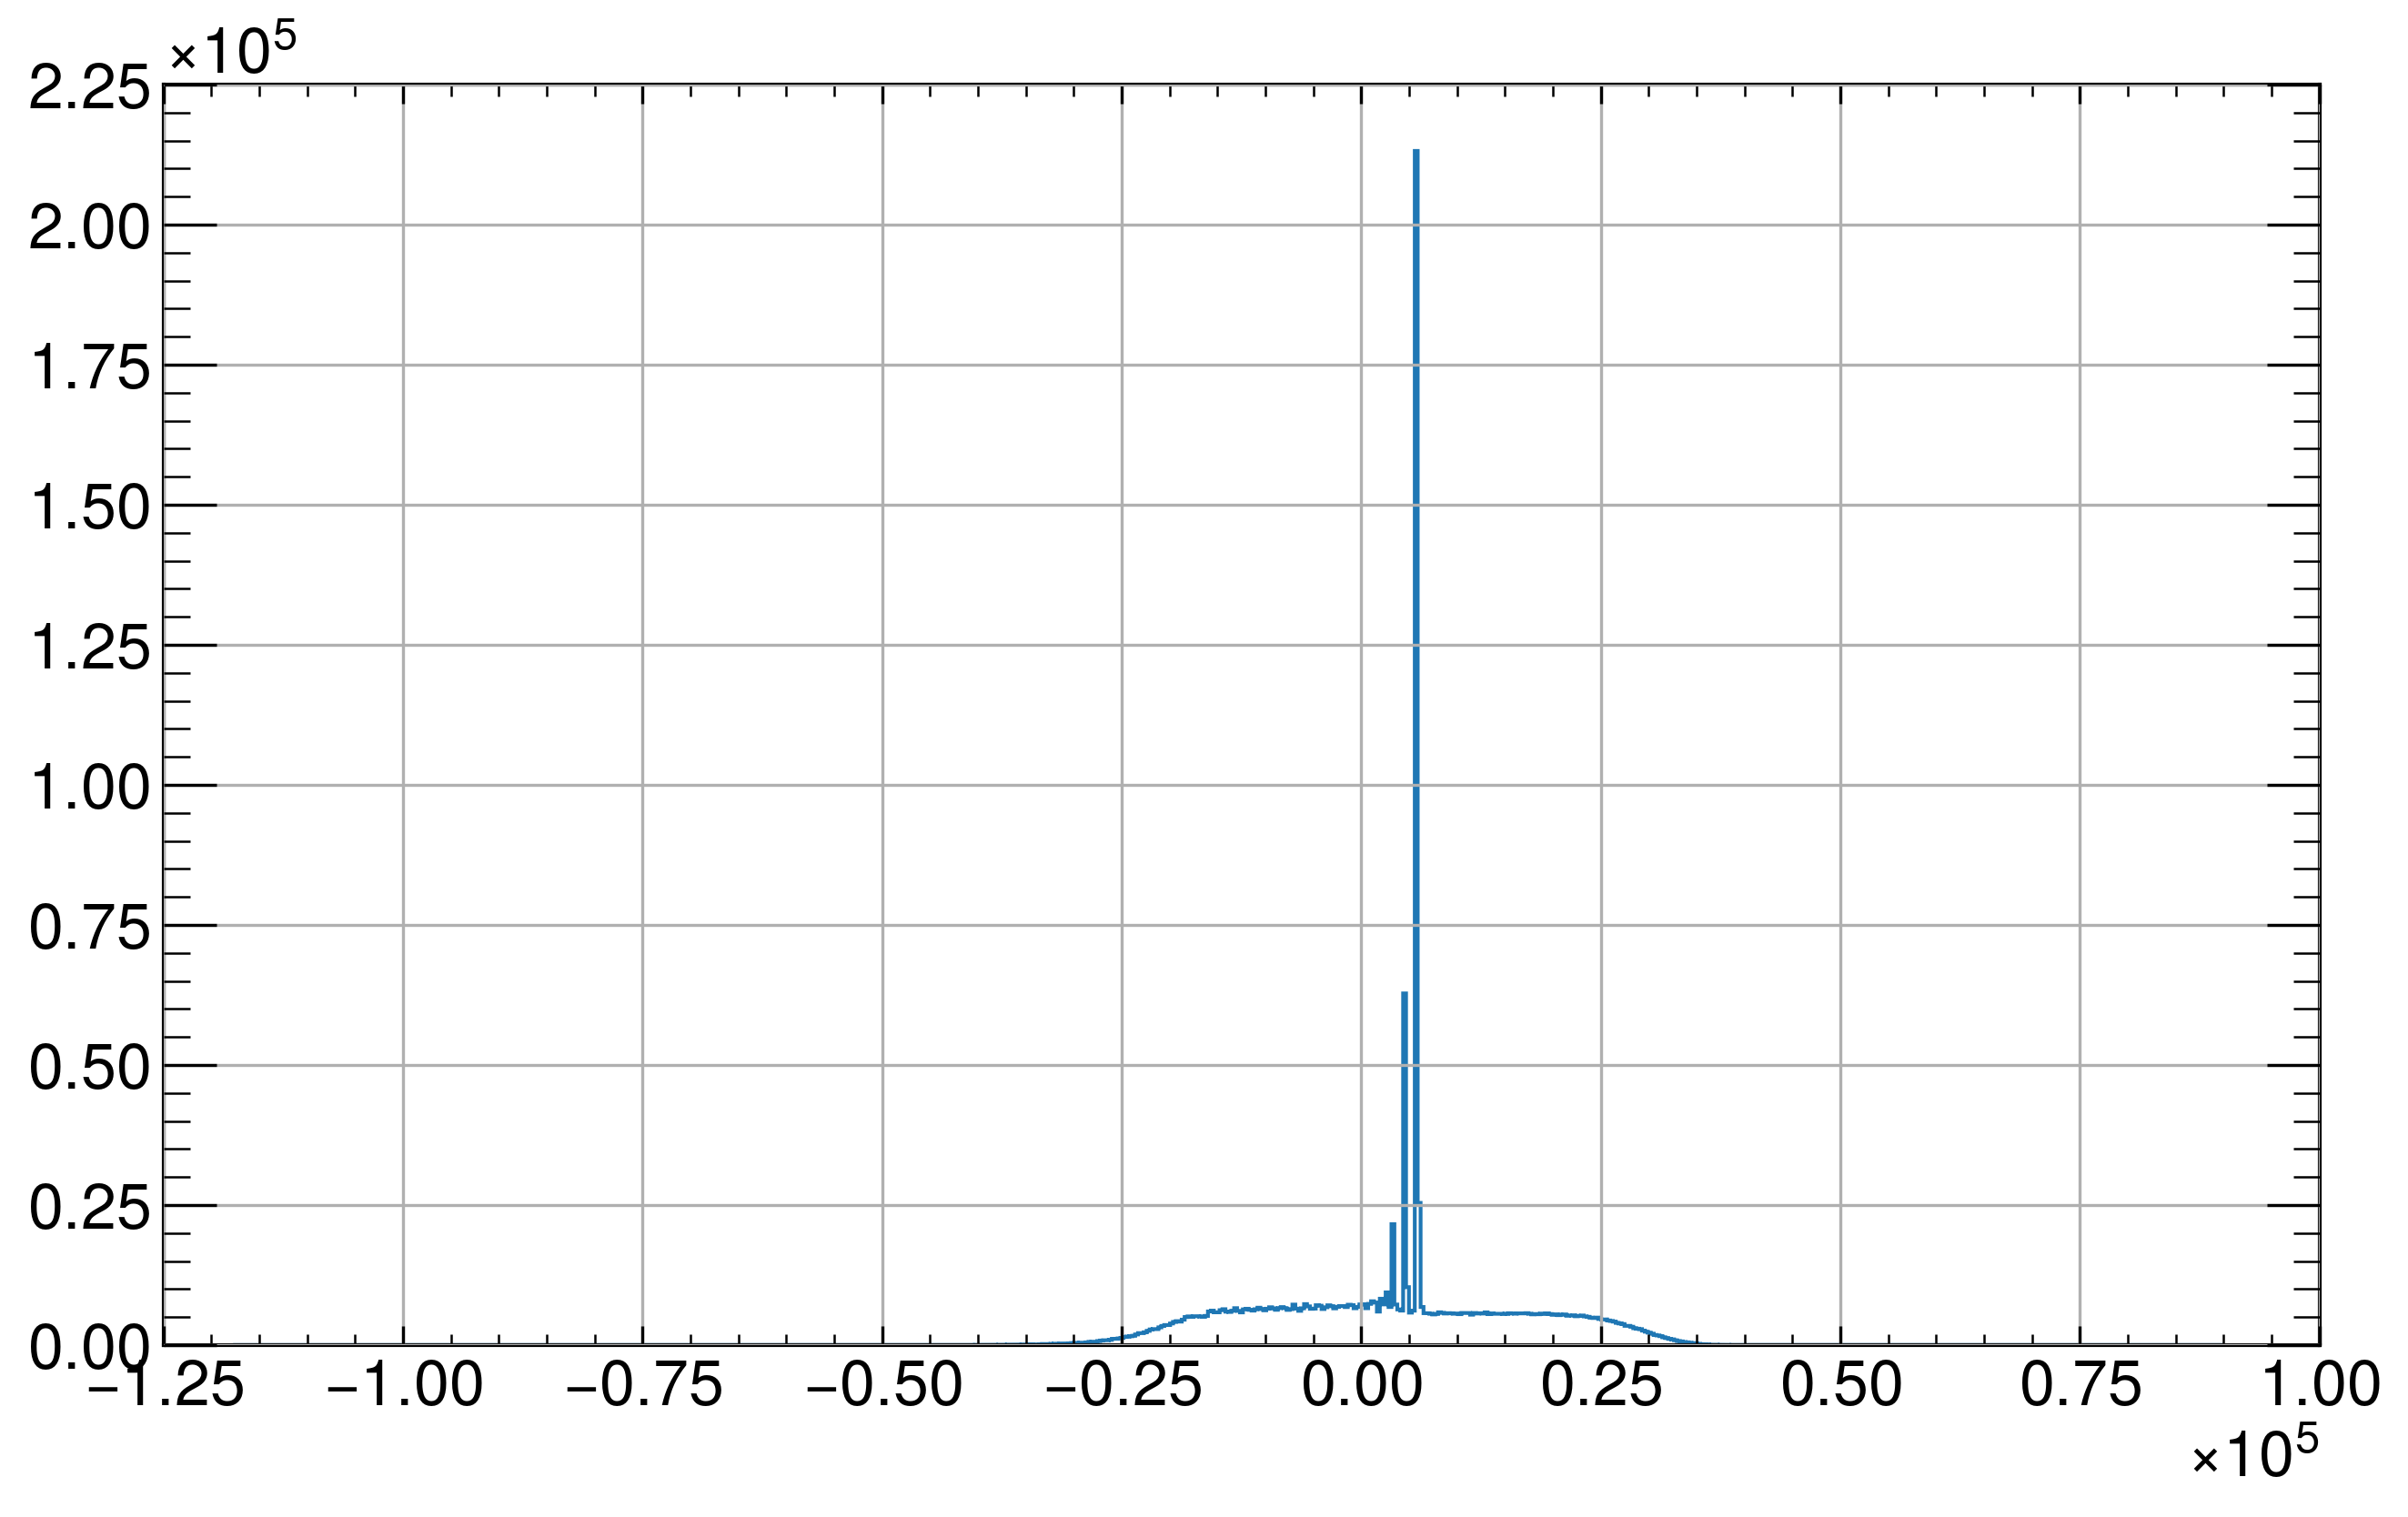

In [64]:

_,_,_,fig,ax = plot_histogram(df[this_scope]["timeCFD20_0"]-df[this_scope]["timeCFD50_3"])
# ax.semilogy()
#add_histogram(ax,df[this_scope]["timeCFD50_1"])
# plt.axvline(5500)

In [ ]:
dict_mins

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')
charge_hist, bins_hist, _ = ax.hist(df[this_scope]["charge_1"].iloc[np.where(
    geometry_1.combine(filter_1, my_and))]/transimpedance,
                                    bins='auto', histtype='step', label='Charge Histogram')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, charge_hist, p0=(10,1,1,4000))
# print(param)
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()
ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
fig.savefig(f"various plots/Charge_distribution_fit_Ch2_{this_batch}.jpg")

In [ ]:
covariance[0,0]**(1/2)

In [ ]:
# fig, ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(df[this_scope]["pulseHeight_1"]>21.3)]/transimpedance)
# ax.plot(bins_centers, pylandau.langau(bins_centers, *param))
# ax.set_xlim(-10, 100)
# legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])
# handles, labels = ax.get_legend_handles_labels()
# handles.append(mpatches.Patch(color='none', label=legend_text))
# ax.axvline(x=4, color='r')
# ax.legend(fontsize=14)
# ax.legend(handles=handles, fontsize=14);
# ax.set_xlabel("Charge [fC]")
# ax.set_title("Batch 301, USTC2.1-W17-P6-A")

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# for i in range(1000,3000,200):

#     bins = i
#     print(find_min_btw_peaks(df[Scope]["pulseHeight_3"], bins=i, prominence=None, distance=10, plot=True))
# ax.set_xlim(-5,20)